# 한국영화에서의 WEAT 스코어

## 1. WEAT 스코어 구하기

In [1]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

In [2]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B

In [3]:
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev


## 2. WEAT 스코어 실험하기

In [4]:
import os

data_dir = '~/aiffel/weat' 
model_dir = os.path.join(data_dir, 'GoogleNews-vectors-negative300.bin')

from gensim.models import KeyedVectors

w2v = KeyedVectors.load_word2vec_format(model_dir, binary=True)

In [5]:
print(len(w2v.vocab))
print(len(w2v['I']))
print(w2v.vectors.shape)

3000000
300
(3000000, 300)


In [6]:
w2v.most_similar(positive=['happy'])

[('glad', 0.7408890724182129),
 ('pleased', 0.6632171869277954),
 ('ecstatic', 0.6626912355422974),
 ('overjoyed', 0.6599286198616028),
 ('thrilled', 0.6514049768447876),
 ('satisfied', 0.6437948942184448),
 ('proud', 0.6360419988632202),
 ('delighted', 0.6272379159927368),
 ('disappointed', 0.6269949674606323),
 ('excited', 0.6247666478157043)]

In [7]:
target_A = ['Adam',  'Harry', 'Josh', 'Roger', 'Alan', 'Frank', 'Justin', 'Ryan', 'Andrew',  'Jack',
'Matthew', 'Stephen', 'Brad', 'Greg',  'Paul',  'Jonathan', 'Peter',  'Amanda', 'Courtney', 'Heather',
'Melanie',  'Katie', 'Betsy', 'Kristin', 'Nancy', 'Stephanie',  'Ellen',
'Lauren',  'Colleen', 'Emily', 'Megan', 'Rachel']
target_B = ['Alonzo', 'Jamel', 'Theo', 'Alphonse', 'Jerome', 'Leroy', 'Torrance', 'Darnell',
'Lamar', 'Lionel',  'Deion', 'Lamont', 'Malik', 'Terrence', 'Tyrone',  'Lavon', 'Marcellus',  'Wardell',
 'Nichelle', 'Shereen',  'Ebony', 'Latisha', 'Shaniqua',  'Jasmine',
'Tanisha', 'Tia', 'Lakisha', 'Latoya',  'Yolanda',  'Malika', 'Yvette']
attribute_X = ['caress', 'freedom', 'health', 'love', 'peace', 'cheer','friend', 'heaven', 'loyal', 'pleasure', 'diamond', 'gentle', 'honest', 'lucky',
'rainbow', 'diploma', 'gift', 'honor', 'miracle', 'sunrise', 'family', 'happy', 'laughter', 'paradise', 'vacation']
attribute_Y = ['abuse', 'crash', 'filth', 'murder', 'sickness', 'accident', 'death', 'grief', 'poison', 'stink', 'assault', 'disaster', 'hatred', 'pollute',
'tragedy', 'bomb', 'divorce', 'jail', 'poverty', 'ugly', 'cancer', 'evil', 'kill', 'rotten', 'vomit']

A = np.array([w2v[word] for word in target_A])
B = np.array([w2v[word] for word in target_B])
X = np.array([w2v[word] for word in attribute_X])
Y = np.array([w2v[word] for word in attribute_Y])

weat_score(X, Y, A, B)

0.39168432

백인 이름은 자유, 건강, 평화와 같은 긍정적인 단어에 가깝고 흑인 이름은 남용, 살인, 병, 사고와 같은 부정적인 단어와 가깝다는 결론을 얻을 수 있다.

## 3. 한국영화 시놉시스로 WEAT 스코어 구하기

### 1. 한국영화 시놉시스로 Word2Vec 구하기

In [23]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

In [24]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. 
w2v = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  

w2v.most_similar(positive=['영화'])

/home/aiffel0038/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('작품', 0.9167312383651733),
 ('다큐멘터리', 0.8753783106803894),
 ('드라마', 0.8412659764289856),
 ('코미디', 0.8103559017181396),
 ('스토리', 0.8071064352989197),
 ('형식', 0.8002126812934875),
 ('영화로', 0.8001941442489624),
 ('주제', 0.7893664836883545),
 ('감동', 0.7875244617462158),
 ('전쟁영화', 0.7863182425498962)]

### 2. 예술영화와 상업영화 시놉시스에서 명사 추출 이후 TF-IDF로 변환하기

In [10]:
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [11]:
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [12]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [13]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


### 3. 예술영화와 상업 영화를 대표하는 단어 추출 & 중복 제거

In [14]:
m1 = X[0].tocoo()
m2 = X[1].tocoo()

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)
w2.sort(key=lambda x: x[1], reverse=True)

for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

In [15]:
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

In [25]:
n = 30
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in w2v.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in w2v.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [26]:
print(target_art)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린', '연인']


In [27]:
print(target_gen)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체', '한국']


### 4. 장르별 영화 명사 추출 이후 TF-IDF로 변환

In [28]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [29]:
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [30]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


### 5. 장르별 영화 대표 명사 추출

In [31]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in w2v:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 

/home/aiffel0038/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  del sys.path[0]


시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 시작, 위해, 사람, 살인, 

### 6. 일반/예술영화와 장르별 영화의 WEAT 스코어 구하기

In [32]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [33]:
A = np.array([w2v.wv[word] for word in target_art])
B = np.array([w2v.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        X = np.array([w2v.wv[word] for word in attributes[i]])
        Y = np.array([w2v.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [34]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] > 1.1 or matrix[i][j] < -1.1:
            print(genre_name[i], genre_name[j],matrix[i][j])

SF 멜로로맨스 -1.3819562
공포(호러) 다큐멘터리 1.1833687
기타 멜로로맨스 -1.2248238
다큐멘터리 멜로로맨스 -1.5381929
다큐멘터리 미스터리 -1.3310063
다큐멘터리 성인물(에로) -1.3262236
다큐멘터리 스릴러 -1.238319
멜로로맨스 뮤지컬 1.1240188
멜로로맨스 범죄 1.2483193
멜로로맨스 서부극(웨스턴) 1.2119213
멜로로맨스 애니메이션 1.2441214
멜로로맨스 액션 1.1704906
멜로로맨스 전쟁 1.4703236
미스터리 전쟁 1.1324996
성인물(에로) 전쟁 1.1321553


SF - 멜로 로맨스 : 상대적으로 SF가 예술영화에 가깝고 멜로로맨스는 상업영화에 가깝다.    
공포 - 다큐멘터리 : 상대적으로 공포영화는 상업영화에 가깝고 다큐멘터리는 예술영화에 가깝다.    
다큐멘터리 - 멜로로맨스 : 상대적으로 다큐멘터리는 예술영화에 가깝고 멜로로맨스는 상업영화에 가깝다.    
다큐멘터리 - 미스테리 : 상대적으로 다큐멘터리는 예술영화에 가깝고 미스터리는 상업영화에 가깝다.    
다큐멘터리 - 성인물 : 상대적으로 다큐멘터리는 예술영화에 가깝고 성인물은 상업영화에 가깝다.    
다큐멘터리 - 스릴러 : 상대적으로 다큐멘터리는 예술영화에 가깝고 스릴러는 상업영화에 가깝다.    
멜로로맨스 - 뮤지컬 : 상대적으로 멜로로맨스는 상업영화에 가깝고 뮤지컬은 예술영화에 가깝다.    
멜로로맨스 - 범죄 : 상대적으로 멜로로맨스는 상업영화에 가깝고 범죄물은 예술영화에 가깝다.    
멜로로맨스 - 서부극 : 상대적으로 멜로로맨스는 상업영화에 가깝고 서부극은 예술영화에 가깝다.    
멜로로맨스 - 애니메이션 : 상대적으로 멜로로맨스는 상업영화에 가깝고 애니메이션은 예술영화에 가깝다.    
맬로로맨스 - 액션 : 상대적으로 멜로로맨스는 상업영화에 가깝고 액션은 예술영화에 가깝다.    
멜로로맨스 - 전쟁 : 상대적으로 멜로로맨스는 상업영화에 가깝고 전쟁은 예술영화에 가깝다.    
미스터리 - 전쟁 : 상대적으로 미스터리는 상업영화에 가깝고 전쟁은 예술영화에 가깝다.    
성인물 - 전쟁 : 상대적으로 성인물은 상업영화에 가깝고 전쟁은 예술영화에 가깝다.    

### 여기서 얻는 결론
다큐멘터리는 장르중 가장 예술영화에 가까운 장르이며 멜로로맨스는 가장 상업영화에 가까운 장르이다.
전쟁물도 에술영화에 가까운 편이며 미스터리, 성인물, 공포, SF등은 상업영화에 가깝다.

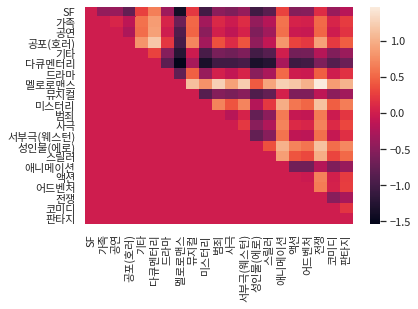

In [35]:
import numpy as np; 
import seaborn as sns; 

np.random.seed(0)

# 한글 지원 폰트
sns.set(font="Noto Sans CJK JP")

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name)
ax

인공지능이 편향되었다는 글의 예시가 대부분 이미지였기에 자연어에서 사용되는 인공지능이 편향되었다는 생각을 하지 못했다.    
이러한 편향성은 이름으로 기쁨/불쾌함을 나누고 이걸 바탕으로 프로그램을 만들때 윤리적 결격사유가 될 수 있을 것이다.    
하지만 영화 분류와 같은 작업을 볼때 편향성도 추천시스템과 같은 시스템에서는 하나의 지표로써 이용될 수 있다는 생각이 들었다.   
인공지능이 갖고 올 수 있는 폐해를 본것 같아 늘 조심하게 접근해야겠다는 생각이 든다.    